------------------------------------------------------
*Machine Learning Course*

*Master in Information & Health Engineering*

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es and Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

**Student:** María Gonzalez García

------------------------------------------------------

In [1]:
!pip uninstall matplotlib -y
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Successfully uninstalled matplotlib-3.7.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl size=11756951 sha256=5d53c7a28936ac7ceaf11fd142805f93fd1b92ef4da5bfb50c9cc9c069be7ff2
  Stored in directory: /root/.cache/pip/wheels/a7/83/5a/c704868d367ace343ac89b928f3d937313a5b5fb5731483705
Successfully built matplotlib
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
arviz 0.15.1 requires matplotlib>=3.2, but you 

# Homework 4: Gaussian Processes

The objective of this practice is to familiarize you with the use of Gaussian Processes, exploring the different extensions that we have seen in the theory session and analyzing the advantages that they can provide us against other models.

For this purpose, in this HW we are going to work with an electrical load estimation problem available in the [UCI data repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency#). Specifically, the problem consists of predicting the heating load (HL) and cooling load (CL) of a set of residential buildings from eight input variables for each building: relative compactness, floor area, wall area, roof area, total height, orientation, glazed area and glazed area distribution.

In [1]:
# You can install GPy using the following command
!pip install GPy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3420842 sha256=b1240a9ef79c2874d7c2fdb4e29228299876d71e8e88e4fa4c348fdaa4d4eb3e
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102543 sha256=7d7c2e947ca78fbb77b3d053cab5dfa12ff83c7524b7112543929a458be01c87
  Stored in directory: /root/.cache/pip/wheels/d2/ef/9c/da9ceef7d0ff5287c24365844fc394852c2b79ac3fcf33bf8b
Successfully built GPy paramz


## Exercise 1. Loading and data set preparation

The following code cell downloads and loads in data set into a dataframe. From this dataframe, divide the data set into training (80%) and test (20%), and normalize the data to zero mean and unit standard deviation.

In [2]:
import pandas as pd
import GPy
import numpy as np
import matplotlib.pyplot as plt


# import the data from the website
data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx')

print('Una muestra de los datos es:')
print(data.head())

# In case you need it

feature_names = {
    'X1': 'Relative Compactness',
    'X2': 'Surface Area',
    'X3': 'Wall Area',
    'X4': 'Roof Area',
    'X5': 'Overall Height',
    'X6': 'Orientation',
    'X7': 'Glazing Area',
    'X8': 'Glazing Area Distribution' }

Una muestra de los datos es:
     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28


In [3]:
X = data.iloc[:,0:8]
Y = data.iloc[:,8:10]

In [4]:
# Split and normalize the data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) # split the data

# split target between HL and CL
HL_train = Y_train[['Y1']].to_numpy().reshape(-1,1)
CL_train = Y_train[['Y2']].to_numpy().reshape(-1,1)
HL_test = Y_test[['Y1']].to_numpy().reshape(-1,1)
CL_test = Y_test[['Y2']].to_numpy().reshape(-1,1)

from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
transformer.fit(X_train) # fit the transformer
X_train_norm = transformer.transform(X_train) # transform
X_test_norm =  transformer.transform(X_test)

Y_train = Y_train.values
Y_test = Y_test.values

## Exercise 2. Learning a basic GP (1.5 points)

Now, let's start working with GPs and their implementation with the GPy library. Since we have two output variables, we are going to train two independent GPs, one to estimate HL and one to estimate CL. For each of the two GPs, you have to:

**In the training data set:**.

a) Build a GP regression model based on an RBF kernel.

b) Fit the parameters of the covariance function and the variance of the noise.

**In the test data set:**

c) Calculate the mean absolute error (MAE) and mean squared error (MSE) on the test data using as model output the a posteriori mean or predicted mean of the GP for the optimized hyperparameters.

Finally, compare both results (heat vs cool) taking into account the parameters adjusted by each model.



In [5]:
kernel_hl = GPy.kern.RBF(input_dim=8, variance=1., lengthscale=1)
kernel_cl = GPy.kern.RBF(input_dim=8, variance=1., lengthscale=1)
m_hl= GPy.models.GPRegression(X_train_norm,HL_train,kernel_hl)
m_cl= GPy.models.GPRegression(X_train_norm,CL_train,kernel_cl)

In [6]:
from IPython.display import display
display(m_hl)
display(m_cl)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [7]:
m_hl.optimize_restarts(num_restarts = 10)
m_cl.optimize_restarts(num_restarts = 10)
display(m_hl)
display(m_cl)

Optimization restart 1/10, f = 766.0805160274075
Optimization restart 2/10, f = 764.4568936118519
Optimization restart 3/10, f = 762.1114470240802
Optimization restart 4/10, f = 764.0892874916264
Optimization restart 5/10, f = 765.8601408898307
Optimization restart 6/10, f = 762.95430466113
Optimization restart 7/10, f = 763.3191295968202
Optimization restart 8/10, f = 762.1470700559071
Optimization restart 9/10, f = 763.8509482583829
Optimization restart 10/10, f = 765.1806648706356
Optimization restart 1/10, f = 1355.4499820072906
Optimization restart 2/10, f = 1355.449982080403
Optimization restart 3/10, f = 1355.4499820029298
Optimization restart 4/10, f = 1355.4499820094327
Optimization restart 5/10, f = 1355.4499820027322
Optimization restart 6/10, f = 1355.4499820029387
Optimization restart 7/10, f = 1355.4499820028682
Optimization restart 8/10, f = 1355.4499820078015
Optimization restart 9/10, f = 1355.4499834592157
Optimization restart 10/10, f = 1355.4499820027468


GP_regression.,value,constraints,priors
rbf.variance,144937079.68351018,+ve,
rbf.lengthscale,18.685569888404025,+ve,
Gaussian_noise.variance,0.1521121642561379,+ve,


GP_regression.,value,constraints,priors
rbf.variance,330.0278466743358,+ve,
rbf.lengthscale,1.698378266858497,+ve,
Gaussian_noise.variance,0.770063323463876,+ve,


In [9]:
mean_hl, st_hl = m_hl.predict(X_test_norm)
mean_cl, st_cl = m_cl.predict(X_test_norm)

# Compute MSE error
MSE_tst_hl = np.mean((HL_test-mean_hl)**2)
MSE_tst_cl = np.mean((CL_test-mean_cl)**2)

# Compute MAE error
MAE_tst_hl = np.mean(abs(HL_test-mean_hl))
MAE_tst_cl = np.mean(abs(CL_test-mean_cl))


print("Heating load\n")
print("MSE: ", MSE_tst_hl)
print("MAE: ", MAE_tst_hl,'\n')

print("Cooling load\n")
print("MSE: ", MSE_tst_cl)
print("MAE: ", MAE_tst_cl)

Heating load

MSE:  0.22197173729100156
MAE:  0.35650204182880657 

Cooling load

MSE:  2.025630369334097
MAE:  0.9592195237314886


**Answer:** The prediction provided in heating load is better in MSE and MAE than cooling load.

## Exercise 2 (extension). Safe estimation of the load production  (0.5 points)

The main objective of the load forecasting problem is to have a good estimate of the energy demand in order to adjust the generation to this demand trying to minimize the production excess and minimizing a failure in the system due to lack of energy production (i.e. that we generate less energy than the demand).

In this section we will make use of the predictive distribution of our model to make a conservative estimate of the energy demand. To do so, instead of considering that the energy demanded will be the mean of the predictive distribution we will consider that in the worst case the energy demanded will be the upper limit of the 95% confidence interval which as we know is given by:
$$ y_{\rm IC 95 sup} = y_{\rm mean} + 1.96* y_{\rm std}$$  
where $y_{\rm mean}$ and $y_{\rm std}$ are, respectively, the mean and standard deviation of the predictive distribution of each sample.

Considering that this model output is a conservative estimate of the load demand (for both HL and CL), obtain the total amount of energy that would be produced in each case and the percentage of *system failures*, i.e., the number of times the load demand is greater than the energy produced over the total number of samples in our test set.

Analyze the obatined results, mainly, discussing whether the percentage of *system failures* matches with expected one.

In [10]:
yIC95sup_hl = mean_hl + 1.96 * np.sqrt(st_hl)
yIC95sup_cl = mean_cl + 1.96 * np.sqrt(st_cl)

HL_prod_conservative = np.sum(yIC95sup_hl)
CL_prod_conservative = np.sum(yIC95sup_cl)

HL_failures = np.sum(HL_test > yIC95sup_hl)
CL_failures = np.sum(CL_test > yIC95sup_cl)

HL_failure_rate = HL_failures / len(HL_test)
CL_failure_rate = CL_failures / len(CL_test)

print("Total energy produced for HL estimation:", HL_prod_conservative)
print("Total energy produced for CL estimation:", CL_prod_conservative)
print("Failure rate for HL:", HL_failure_rate)
print("Failure rate for CL:", CL_failure_rate)

Total energy produced for HL estimation: 3723.7858237927367
Total energy produced for CL estimation: 4316.486376143093
Failure rate for HL: 0.01948051948051948
Failure rate for CL: 0.045454545454545456


**Answer:** Considering the above results, more energy is needed for the cooling load than for the heating load, but there is a higher percentage of system failures in the cooling load. This could be related to equipment malfunction, insufficient capacity or problems with the control and maintenance of the cooling system.

## Exercise 3. Analysis of the input feature relevances (2 points)

As we know, we can combine the above GPs design with an ARD so that each input dimension is weighted with a different scale length in order to analyze the relevance of each variable in the model.

Modify the above design so that the kernel includes an ARD and based on the ARD parameters found, indicate which variables are most important for the regression. Do not forget to include in the kernel design some constant noise term (in case all the input variables drop out of weight).


Next, train a Random Forest for regression and use the `feature_importances` parameter of this model to also analyze the relevance of each variable.

Compare the results with those of the previous model and discuss the similarities or differences between the most relevance features. For this analysis, you may find it useful to analyze the correlations between the input features.

In [ ]:
#GP model

kernel_hl_1 = GPy.kern.RBF(input_dim=8, variance=1., lengthscale=1,ARD=True) + GPy.kern.White(2)
kernel_cl_1 = GPy.kern.RBF(input_dim=8, variance=1., lengthscale=1,ARD=True) + GPy.kern.White(2)
m_hl_1= GPy.models.GPRegression(X_train_norm,HL_train,kernel_hl_1)
m_cl_1= GPy.models.GPRegression(X_train_norm,HL_train,kernel_cl_1)

m_hl_1.optimize(messages=False,max_f_eval = 1000)
m_cl_1.optimize(messages=False,max_f_eval = 1000)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#Random Forest model

rf_model_hl = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_hl.fit(X_train_norm, np.ravel(HL_train))

rf_model_cl = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_cl.fit(X_train_norm, np.ravel(CL_train))

mean_hl = rf_model_hl.predict(X_test_norm)
mean_cl = rf_model_cl.predict(X_test_norm)

# Compute MSE error
MSE_tst_hl_rf = np.mean((HL_test-mean_hl)**2)
MSE_tst_cl_rf = np.mean((CL_test-mean_cl)**2)

# Compute MAE error
MAE_tst_hl_rf = np.mean(abs(HL_test-mean_hl))
MAE_tst_cl_rf = np.mean(abs(CL_test-mean_cl))

print("Heating load\n")
print("MSE: ", MSE_tst_hl_rf)
print("MAE: ", MAE_tst_hl_rf,'\n')

print("Cooling load\n")
print("MSE: ", MSE_tst_cl_rf)
print("MAE: ", MAE_tst_cl_rf)

Heating load

MSE:  202.14801949855118
MAE:  11.426383951762523 

Cooling load

MSE:  179.82295223832347
MAE:  10.785701998650698


**Answer:** The MSE gets a higher error than the MAE. One reason for this could be that the MSE error gives more weight to higher errors due to the square of the difference and the MAE gives the same weight equally. Still we get larger errors using Random Forest than GPRegression.

In [ ]:
#Feature importance

#GP model
lengthscales_hl = kernel_hl_1.rbf.lengthscale.values / np.sum(kernel_hl_1.rbf.lengthscale.values)
lengthscales_cl = kernel_cl_1.rbf.lengthscale.values / np.sum(kernel_cl_1.rbf.lengthscale.values)

#Random Forest model
feature_importance_hl = rf_model_hl.feature_importances_
feature_importance_cl = rf_model_cl.feature_importances_

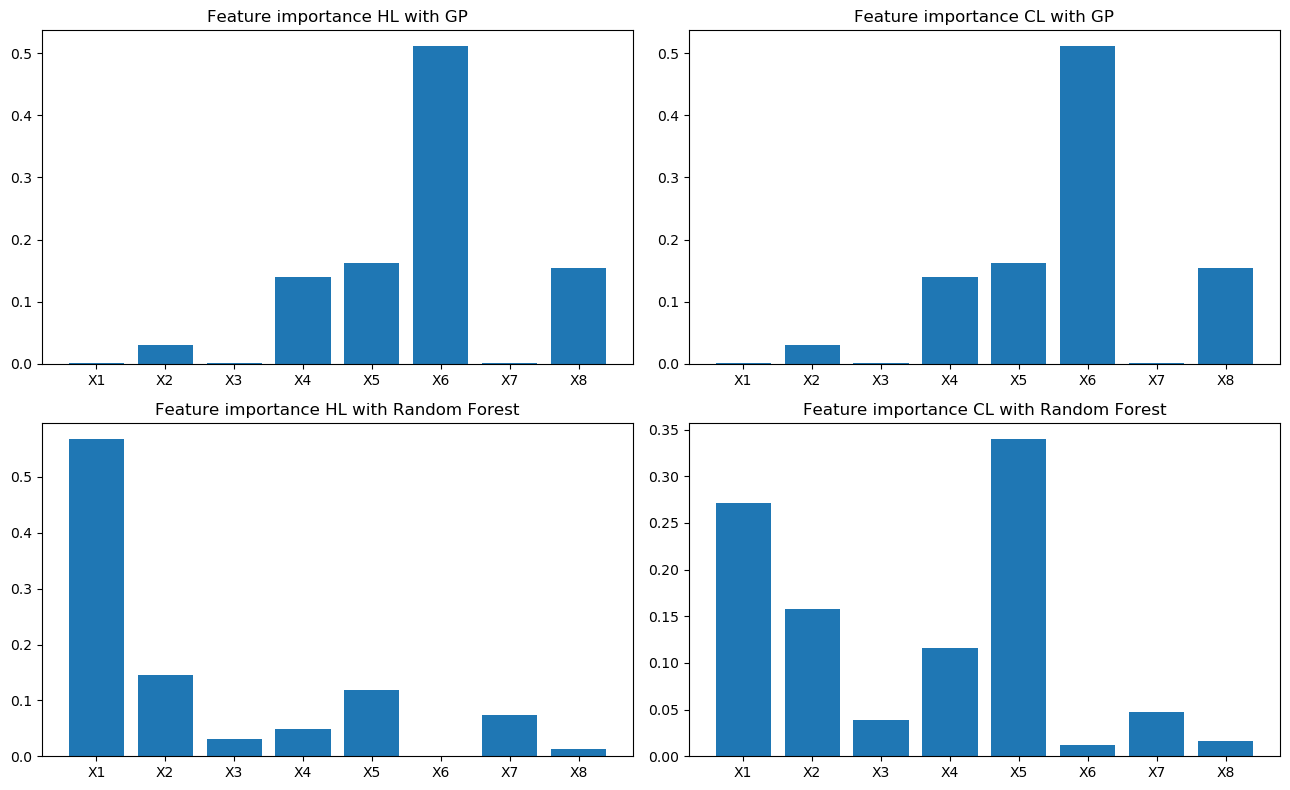

In [ ]:
gp_importances_hl = pd.Series(lengthscales_hl, index=feature_names)
gp_importances_cl = pd.Series(lengthscales_cl, index=feature_names)
forest_importances_hl = pd.Series(feature_importance_hl, index=feature_names)
forest_importances_cl = pd.Series(feature_importance_cl, index=feature_names)

plt.figure(figsize=(13, 8))

plt.subplot(2, 2, 1)
plt.bar(gp_importances_hl.index, gp_importances_hl)
plt.title("Feature importance HL with GP")

plt.subplot(2, 2, 2)
plt.bar(gp_importances_cl.index, gp_importances_cl)
plt.title("Feature importance CL with GP")

plt.subplot(2, 2, 3)
plt.bar(forest_importances_hl.index, forest_importances_hl)
plt.title("Feature importance HL with Random Forest")

plt.subplot(2, 2, 4)
plt.bar(forest_importances_cl.index, forest_importances_cl)
plt.title("Feature importance CL with Random Forest")

plt.tight_layout()
plt.show()

**Answer:** With GP we can obtain the importance of the feature on the length scale value, which means that the lower the value, the higher the importance. This approach is opposite with Random Forest feature importance, where a higher value means higher importance.

This result can be seen in the figures above, when a feature gets a high value in the Random Forest feature importance, the GP feature importance gives a low value. An example is the first feature in the heating load, where the Random Forest assigns 0.7 approx and a GP less than 0.1, implying that this feature is relevant. We can see the same behavior in the cooling load.

Therefore, for the heating load the most relevant feature for estimation is X1. However, for cooling load it is X5 and X1.

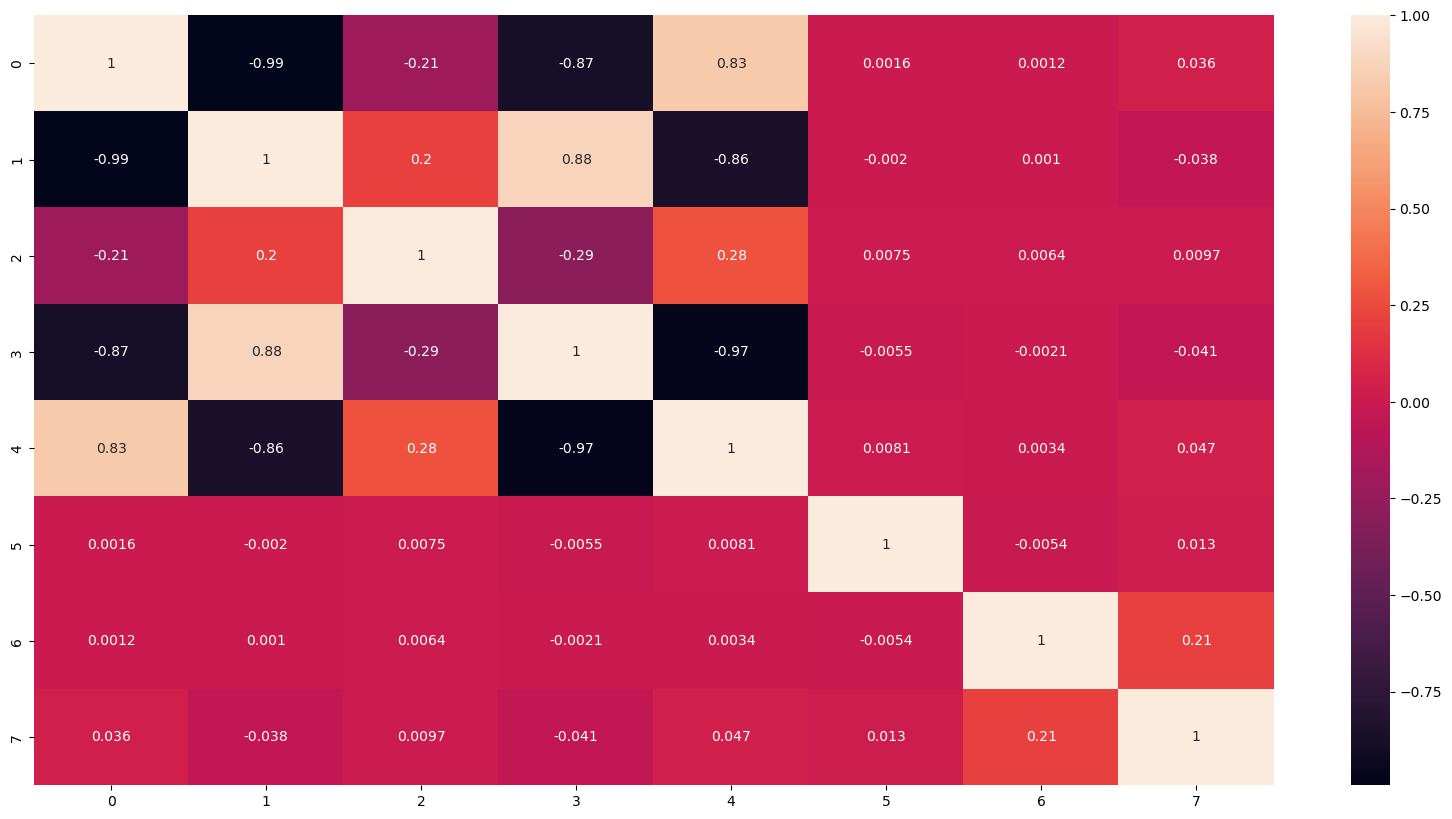

In [ ]:
import seaborn as sns
f, ax = plt.subplots(figsize=(20, 10))
corr = pd.DataFrame(X_train_norm).corr()
sns.heatmap(corr,annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

**Answer:** This correlation matrix gives important information about the relationship between the different features. It can be seen that X1 is highly correlated with X2, X4, X5. This can give an idea that all these features shareinformation, indicating redundancy, and it might be possible to simplify the model by removing one or more of these.

The GP assigns the importance of each feature independtly, but Random forest assigns considering all the feature dataset. That is the reason why we can see differences in the above plots.

GP divide the length scale of each feature.

The correlation matrix: 1 2 4 y 5 --> many possible solutions Solo darle mas relevancia a una features o que le da la misma relevancia a esas muy correladas. --> Esto para GP


Random features: random subsets. Para el primero es 1 para el segundo es la 4 y asi haciendo el average y dividiendo la relevancia a esas que están highly correlated. Spliting the relevance between all the features highly correlated

## Exercise 4. Improving the GP performance with a good kernel design (2 points)

In this section we are going to try to improve the performance of the previous GP (for both HL and CL) by using a more complicated kernel, in which we combine several covariance functions, and which is able to better fit the data.

Test several kernel designs by making combinations using sums and products and for the best design obtained calculate the performance in terms of MAE and MSE. In addition, analyze if this design allows to improve the performance of the conservative load estimation in terms of total energy generated and presence of faults (extension of Exercise 2). For these designs continue considering the ARD-kernel in order not to lose the interpretability of the model. Among the combinations to check, I advise to include:
* Matern kernel 52   
* Matern kernel 32
* RadQuad

and their linear combinations with RBF kernel.




For the remainder of the practice consider as kernel the sum of a RBF and a Matern52 kernel with ARD.

In [ ]:
def evaluate_gp_model(model, X_test, Y_test):
    mean, var = model.predict(X_test)
    mae = np.mean(abs(Y_test-mean))
    mse = np.mean((Y_test-mean)**2)
    return mae, mse

def gp_model(X_train,Y_train,kernel):
    model = GPy.models.GPRegression(X_train, Y_train, kernel)
    model.optimize_restarts(num_restarts=10, verbose=False)
    return model

In [ ]:
kernel_combinations = [
    GPy.kern.RBF(input_dim=X_train_norm.shape[1],ARD=True, variance=1., lengthscale=1),
    GPy.kern.Matern32(input_dim=X_train_norm.shape[1],ARD=True, variance=1., lengthscale=1),
    GPy.kern.Matern52(input_dim=X_train_norm.shape[1],ARD=True, variance=1., lengthscale=1),
    GPy.kern.RatQuad(input_dim=X_train_norm.shape[1],ARD=True, variance=1., lengthscale=1),
    GPy.kern.Linear(input_dim=X_train_norm.shape[1],ARD=True),
    GPy.kern.RBF(input_dim=X_train_norm.shape[1],ARD=True, variance=1., lengthscale=1) + GPy.kern.Linear(input_dim=X_train_norm.shape[1],ARD=True),
    GPy.kern.RBF(input_dim=X_train_norm.shape[1],ARD=True, variance=1., lengthscale=1) * GPy.kern.Linear(input_dim=X_train_norm.shape[1], ARD=True),
    GPy.kern.RBF(input_dim=X_train_norm.shape[1], ARD=True, variance=1., lengthscale=1) + GPy.kern.Matern52(input_dim=X_train_norm.shape[1],ARD=True, variance=1., lengthscale=1),
]

MAE_HL=[]
MSE_HL=[]

MAE_CL=[]
MSE_CL=[]

for kernel in kernel_combinations:

    model_HL = gp_model(X_train_norm, HL_train, kernel.copy())
    model_CL = gp_model(X_train_norm, CL_train, kernel.copy())

    # Evaluate on test data for HL
    mae_HL, mse_HL = evaluate_gp_model(model_HL, X_test_norm, HL_test)

    MAE_HL.append(mae_HL)
    MSE_HL.append(mse_HL)

    # Evaluate on test data for CL
    mae_CL, mse_CL = evaluate_gp_model(model_CL, X_test_norm, CL_test)

    MAE_CL.append(mae_CL)
    MSE_CL.append(mse_CL)

 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:487: RuntimeWarning:invalid value encountered in multiply
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:invalid value encountered in multiply
 /usr/local/lib/pytho

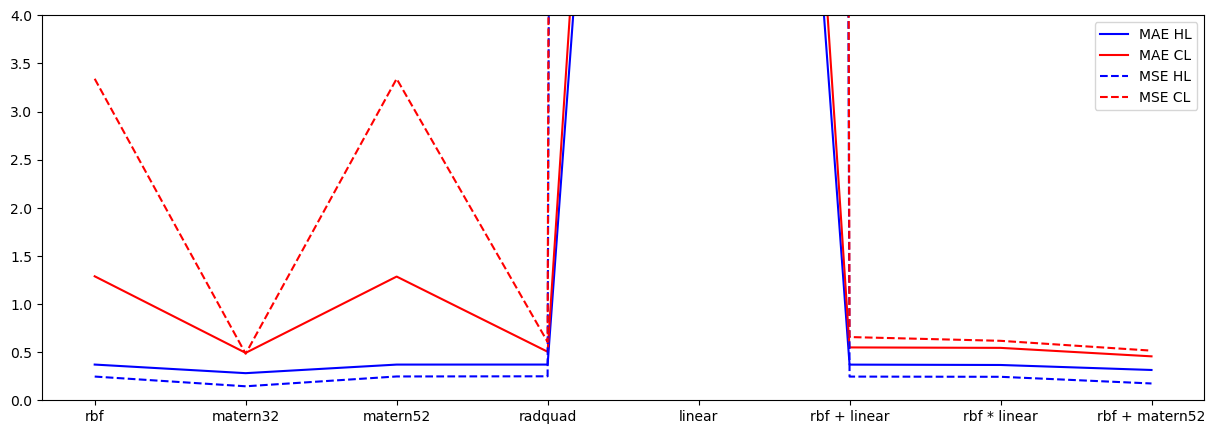

In [ ]:
kernel_labels = ['rbf', 'matern32', 'matern52' ,'radquad', 'linear', 'rbf + linear', 'rbf * linear','rbf + matern52']
plt.figure(figsize=(15,5))
plt.plot(MAE_HL,'b', label='MAE HL')
plt.plot(MAE_CL,'r', label='MAE CL')
plt.plot(MSE_HL,'b--', label='MSE HL')
plt.plot(MSE_CL,'r--',label='MSE CL')
plt.legend()
plt.xticks(range(len(kernel_labels)), kernel_labels)
plt.ylim(0,4)
plt.show()

**Answer:** The figure above shows the MSE and MAE obtained using different kernel types and combinations. The warm-up load still gives lower errors in MSE and MAE in all kernels. The linear kernel obtains higher errors compared to other kernels, so this kernel has difficulty capturing patterns in the data, resulting in less accurate predictions. The combination of the "RBF" and "MATERN52" kernels provides the lowest error values for both heating load and cooling load estimates.

## Exercise 5. Comparison with Kernel Ridge Regression (KRR) (1 point)

As we have seen in the theory session, the predictive mean of our GP (linear) matches the solution of the Ridge Regression model, and the same is true if we use kernel versions in both models. However, there are significant differences between the two models that we will analyze in this section.

To do this, solve the above problems (HL and CL) using a KRR and analyze how they perform in performance (MAE and MSE), training and test times.

If for the KRR model you want to use a complex kernel (for instance, the sum of a RBF and a Matern52 kernel) you can use those from [sklearn's GP kernel library](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes) with the KRR model. In this case, be careful how you explore the model parameters to prevent the cross-validation process from being endless.

Finally, discuss the advantages/disadvantages of this model in comparison to GPs.


In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF, Matern

def evaluate_krr_model(model, X, Y):
    mean = model.predict(X)
    mae = np.mean(abs(Y-mean))
    mse = np.mean((Y-mean)**2)
    return mae, mse

In [ ]:
#GP model
start_time = time()

kernel = GPy.kern.RBF(input_dim=X_train_norm.shape[1], ARD=True, lengthscale=1) + GPy.kern.Matern52(input_dim=X_train_norm.shape[1],ARD=True, lengthscale=1)

model_HL = gp_model(X_train_norm, HL_train, kernel.copy())
model_CL = gp_model(X_train_norm, CL_train, kernel.copy())

mae_HL_test, mse_HL_test = evaluate_gp_model(model_HL, X_test_norm, HL_test)
mae_HL_train, mse_HL_train = evaluate_gp_model(model_HL, X_train_norm, HL_train)

mae_CL_test, mse_CL_test = evaluate_gp_model(model_CL, X_test_norm, HL_test)
mae_CL_train, mse_CL_train = evaluate_gp_model(model_CL, X_train_norm, HL_train)

time_model = time() - start_time

 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:invalid value encountered in multiply
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:584: RuntimeWarning:invalid value encountered in subtract
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide


In [ ]:
print("---- Train evaluation GP-----\n")

print("Heating load\n")
print("MSE: ", mse_HL_train)
print("MAE: ", mae_HL_train,'\n')

print("Cooling load\n")
print("MSE: ", mse_CL_train)
print("MAE: ", mae_CL_train,'\n')

print("---- Test evaluation GP-----\n")

print("Heating load\n")
print("MSE: ", mse_HL_test)
print("MAE: ", mae_HL_test,'\n')

print("Cooling load\n")
print("MSE: ", mse_CL_test)
print("MAE: ", mae_CL_test,"\n")

print("Time model: ",time_model)

---- Train evaluation GP-----

Heating load

MSE:  0.10682136095763606
MAE:  0.2296129200441114 

Cooling load

MSE:  9.772026826336807
MAE:  2.645578090460753 

---- Test evaluation GP-----

Heating load

MSE:  0.17825276729536363
MAE:  0.30908835405506446 

Cooling load

MSE:  10.573440175580876
MAE:  2.7195710565219287 

Time model:  539.8726561069489


In [ ]:
#Kernel Ridge Regression

start_time = time()

kernel =  RBF(length_scale=1) + Matern(length_scale=1, nu=3)

#Heating load
krr_hl = KernelRidge(kernel=kernel).fit(X_train_norm, HL_train)

mae_hl_train, mse_hl_train=evaluate_krr_model(krr_hl,X_train_norm,HL_train)
mae_hl_test, mse_hl_test=evaluate_krr_model(krr_hl,X_test_norm,HL_test)

#Cooling load
krr_cl = KernelRidge(kernel=kernel).fit(X_train_norm, CL_train)

mae_cl_train, mse_cl_train=evaluate_krr_model(krr_cl,X_train_norm,CL_train)
mae_cl_test, mse_cl_test=evaluate_krr_model(krr_cl,X_test_norm,CL_test)

time_model = time() - start_time

In [ ]:
print("---- Train evaluation Ridge-----\n")

print("Heating load\n")
print("MSE: ", mse_hl_train)
print("MAE: ", mae_hl_train,'\n')

print("Cooling load\n")
print("MSE: ", mse_cl_train)
print("MAE: ", mae_cl_train,'\n')

print("---- Test evaluation Ridge-----\n")

print("Heating load\n")
print("MSE: ", mse_hl_test)
print("MAE: ", mae_hl_test,'\n')

print("Cooling load\n")
print("MSE: ", mse_cl_test)
print("MAE: ", mae_cl_test,"\n")

print("Time model: ",time_model)

---- Train evaluation -----

Heating load

MSE:  2.6957723504090745
MAE:  1.1563104539111684 

Cooling load

MSE:  3.5002757412325614
MAE:  1.3184588510043884 

---- Test evaluation -----

Heating load

MSE:  7.622529092078101
MAE:  2.0306513689036767 

Cooling load

MSE:  11.962206222319676
MAE:  2.340772362514551 

Time model:  1.548365592956543


**Answer:** One of the main differences between Kernel Rige Regression and GP Regression is the computation time. It can be seen how, despite being trained with the same data and the same kernel, Rige takes 1.5 seconds and GP 9 minutes. So, Ridge can handle larger datasets more efficiently than GPs.However, this time is compensated in the error obtained. In general, GP obtains a lower error in its estimations.

## Exercise 6. Using sparse GPs (2 points)

Implement a sparse version of the above GPs optimized to find a set of **inducing points** on which the GP can rely to make the prediction. Measure the performance of the model (analyze the marginal likelihood of the model and the MSE) for 20, 40 and 100 inducing points and discuss whether the sparse solution is adequate.



In [ ]:
from time import time

num_inducing_points = [20, 40, 100]

MAE_HL=[]
MSE_HL=[]

MAE_CL=[]
MSE_CL=[]

for num_points in num_inducing_points:

  inducing_points_idx = np.random.choice(len(X_train_norm), num_points, replace=False)
  inducing_points = X_train_norm[inducing_points_idx, :]

  start_time = time()

  kernel = GPy.kern.RBF(input_dim=X_train_norm.shape[1], lengthscale=1) + GPy.kern.Matern52(input_dim=X_train_norm.shape[1],lengthscale=1)

  m_hl = GPy.models.SparseGPRegression(X_train_norm,HL_train,Z=inducing_points, kernel=kernel.copy())
  m_cl = GPy.models.SparseGPRegression(X_train_norm,CL_train,Z=inducing_points,kernel=kernel.copy())

  m_hl.optimize(messages=False)
  m_cl.optimize(messages=False)

  mae_HL, mse_HL = evaluate_gp_model(m_hl, X_test_norm, HL_test)
  mae_CL, mse_CL = evaluate_gp_model(m_cl, X_test_norm, CL_test)

  time_model = time() - start_time

  print(f"Number of Inducing Points: {num_points}\n")
  print("Heating load\n")
  print(f"MSE: {mse_HL:.4f}")
  print(f"MAE: {mae_HL:.4f}\n")
  print("Cooling load\n")
  print(f"MSE: {mse_CL:.4f}")
  print(f"MAE: {mae_CL:.4f}\n")
  print("Time: ", time_model,"\n")

Number of Inducing Points: 20

Heating load

MSE: 7.1177
MAE: 1.8539

Cooling load

MSE: 12.0334
MAE: 2.4566

Time:  89.8953914642334 

Number of Inducing Points: 40

Heating load

MSE: 5.7835
MAE: 1.7104

Cooling load

MSE: 10.3402
MAE: 2.2948

Time:  108.09410834312439 

Number of Inducing Points: 100

Heating load

MSE: 2.1596
MAE: 1.1206

Cooling load

MSE: 6.4513
MAE: 1.8946

Time:  190.7132453918457 



**Answer:** it can be verified that greater number of inducing points obtain a reduction in both evaluation metrics. However, the computaion stime increase and also the complexity of the model. There is always a trade-off between the model accuracy and computational efficiency.

When comparing the sparse GP and the general GP, it is observed that using inductor points has reduced the computational time, but increases the MSE/MAE. Therefore, the sparse GP gives a solution that is not so far away from the general GP, using reduced points and computational time.

## Exercise 7. Comparison with a SVR (1 point)

To fully analyze the advantages of the sparse GP we have just designed compare its performance (MSE, MAE and training and execution times) with a Support Vector Machine for regression which as we know is also able to provide sparse solutions. Compare also the sparsity of both solutions, choose the sparse GP from the previous section that you consider more suitable and compare its number of *inducing points* with the number of support vectors of the SVR.

For the SVR you can use either a RBF kernel or a complex one (for instance RBF+MAtern52) using the GP kernel library.



In [ ]:
from time import time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

rang_C = np.logspace(-3, 3, 10)
n_dim=X_train_norm.shape[1]
rang_g=np.array([0.125, 0.25, 0.5, 1, 2, 4, 8])/(n_dim)

param_grid = {
    'C': rang_C,  # Regularization parameter
    'epsilon': [0.1, 0.2, 0.5],  # Epsilon parameter
    'gamma': rang_g
}

SVR_model = SVR(kernel='rbf')

grid_search = GridSearchCV(SVR_model, param_grid, cv=5)

grid_search.fit(X_train_norm, HL_train.ravel())

print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'C': 1000.0, 'epsilon': 0.1, 'gamma': 0.125}


In [ ]:
start_time = time()
SVR_model_hl = SVR(kernel='rbf', C=1000,epsilon=0.1,gamma=0.125).fit(X_train_norm, HL_train.ravel())

mae_hl, mse_hl=evaluate_krr_model(SVR_model_hl,X_test_norm,HL_test)

time_h = time() - start_time

In [ ]:
from time import time
rang_C = np.logspace(-3, 3, 10)
n_dim=X_train_norm.shape[1]
rang_g=np.array([0.125, 0.25, 0.5, 1, 2, 4, 8])/(n_dim)

param_grid = {
    'C': rang_C,  # Regularization parameter
    'epsilon': [0.1, 0.2, 0.5],  # Epsilon parameter
    'gamma': rang_g
}


SVR_model = SVR(kernel='rbf')

grid_search = GridSearchCV(SVR_model, param_grid, cv=5)

grid_search.fit(X_train_norm, CL_train.ravel())

print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'C': 215.44346900318823, 'epsilon': 0.2, 'gamma': 0.25}


In [ ]:
start_time = time()
SVR_model_cl = SVR(kernel='rbf', C=215.44346900318823,epsilon=0.2,gamma=0.25).fit(X_train_norm, CL_train.ravel())

mae_cl, mse_cl=evaluate_krr_model(SVR_model_cl,X_test_norm,CL_test)

time_c = time() - start_time

In [ ]:
print("Heating load\n")
print(f"Number of support vectors {len(SVR_model_hl.support_vectors_)} ")
print("MSE: ", mse_hl)
print("MAE: ", mae_hl,'\n')


print("Time: ",time_h)

print("Cooling load\n")
print(f"Number of support vectors {len(SVR_model_cl.support_vectors_)} ")
print("MSE: ", mse_cl)
print("MAE: ", mae_cl,'\n')


print("Time: ",time_c)

Heating load

Number of support vectors 482 
MSE:  202.14705272958227
MAE:  11.428279062275973 

Time:  5.506841659545898
Cooling load

Number of support vectors 488 
MSE:  180.98029349447893
MAE:  10.818864369236021 

Time:  0.7291827201843262


**Answer:** It can be seen that the errors obtained with the SVR are higher than those obtained with the sparse version of GP, even when using a larger number of support vectors compared to the inducing points. However, the computational time with 400 support vectors in a SVR is much shorter compared to the time taken with the sparse version of GP with only 100 points.